In [ ]:
# Importing the Libraries
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tokenize import RegexpTokenizer
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re  
import spacy
#import en_core_web_sm
#nlp = en_core_web_sm.load()
nlp = spacy.load('en',disable=['parser', 'tagger','ner'])
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
# Importing the dataset
# Link for dataset: https://www.gutenberg.org/files/1661/1661-0.txt
text = open("Sherlock.txt", 'rb').read().decode(encoding='utf-8')
print ('Book contains a total of {} characters'.format(len(text)))

Book contains a total of 594199 characters


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
""" 
# Increasing the training data 
## Not feasible because system crashing due t unavailability of RAM
data = data2  = "" 

# Reading data from file1 
with open('Sherlock.txt') as fp: 
	data = fp.read() 

# Reading data from file2 
with open('return.txt') as fp: 
	data2 = fp.read() 
  

# Merging 2 files 
# To add the data of file2 
# from next line 
#data += "\n"
data = data+"\n"+data2

with open ('finel.txt', 'w') as fp: 
	fp.write(data) 

#nlp.max_length = 1274990

text = open("finel.txt", 'rb').read().decode(encoding='utf-8')
print ('Book contains a total of {} characters'.format(len(text)))
"""

In [ ]:
## Snippet of the book
print(text[1300:1400])


I. A SCANDAL IN BOHEMIA


I.

To Sherlock Holmes she is always _the_ woman. I have seldom hear


In [ ]:
#Tokenizing the data
sentences = sent_tokenize(text)
tokenizer = RegexpTokenizer('[A-Za-z]\w+')
tokens=tokenizer.tokenize(text)
#print(tokens)

In [ ]:
# Converting tokens to dataframes for exploring the dataset 
df = pd.DataFrame(tokens)
df = df[0].value_counts()

In [ ]:
#This will give frequencies of words

from nltk.probability import FreqDist
freqdoctor = FreqDist()
for words in df:
    freqdoctor[words] += 1

#freqdoctor

In [ ]:
#This dataframe shows the top 20 words being used

df = df[:20,]
df

the      5428
and      2888
to       2790
of       2737
in       1750
that     1664
was      1394
it       1303
you      1286
he       1168
is       1129
his      1103
have      909
my        907
with      850
had       822
as        780
which     770
at        742
for       716
Name: 0, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


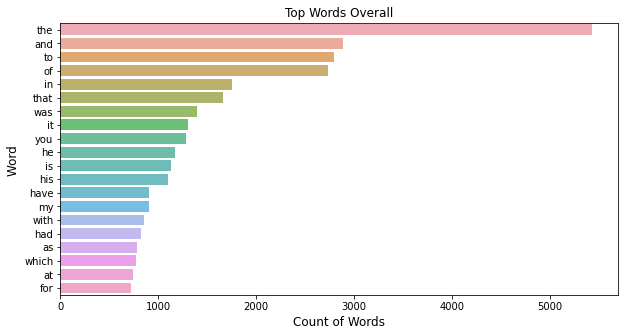

In [ ]:
#This is a plot that shows the top 20 words being used

plt.figure(figsize=(10,5))
sns.barplot(df.values, df.index, alpha=0.8)
plt.title('Top Words Overall')
plt.ylabel('Word ', fontsize=12)
plt.xlabel('Count of Words', fontsize=12)
plt.show()

###Preprocessing the data

In [ ]:
# Removed first 1300 characters to remove details related to project gutenberg
text = text [1300:]

In [ ]:
# cleaning text by removing punctuations
def separate_punc(doc_text):
    return [token.text.lower() for token in nlp(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n \r\n\r\n\r\n \r\n\r\n']
tokens = separate_punc(text)
#tokens

In [ ]:
len(tokens)

115189

###Prepare Dataset

We leverage a sliding window approach to train out model. We first set the maximum sequence length to 25 words. This is done for the purposes of preparing and training batches.

In [ ]:
# Creating Sequence of tokens
# organize into sequences of tokens
train_len = 25+1 # 50 training words , then one target word

# Empty list of sequences
text_sequences = []

for i in range(train_len, len(tokens)):
    
    # Grab train_len# amount of characters
    seq = tokens[i-train_len:i]
    
    # Add to list of sequences
    text_sequences.append(seq)

In [ ]:
' '.join(text_sequences[0])

'i. a scandal in bohemia i. to sherlock holmes she is always the woman i have seldom heard him mention her under any other name in'

In [ ]:
len(text_sequences)

115163

In [ ]:
### Character to Integer Mapping
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

In [ ]:
#sequences[0]

In [ ]:
#tokenizer.index_word

In [ ]:
for i in sequences[0]:
    print(f'{i} : {tokenizer.index_word[i]}')

465 : i.
7 : a
981 : scandal
9 : in
1057 : bohemia
465 : i.
4 : to
136 : sherlock
36 : holmes
41 : she
16 : is
229 : always
1 : the
194 : woman
3 : i
18 : have
1832 : seldom
121 : heard
38 : him
4562 : mention
40 : her
268 : under
93 : any
96 : other
217 : name
9 : in


In [ ]:
#tokenizer.word_counts
vocabulary_size = len(tokenizer.word_counts)

In [ ]:
# Converting seuence to numpy matrix
sequences = np.array(sequences)
sequences

array([[ 465,    7,  981, ...,   96,  217,    9],
       [   7,  981,    9, ...,  217,    9,   15],
       [ 981,    9, 1057, ...,    9,   15,  152],
       ...,
       [ 799,    4,    1, ...,    4,  361,   84],
       [   4,    1,  158, ...,  361,   84,  371],
       [   1,  158,  159, ...,   84,  371, 1833]])

In [ ]:
# Creating LSTM based Model
from keras.models import Sequential
from keras.layers import Dense,LSTM,Embedding,Dropout
def create_model(vocabulary_size, seq_len):
    model = Sequential()
    model.add(Embedding(vocabulary_size, 25, input_length=seq_len))
    model.add(LSTM(250, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(250))
    model.add(Dense(200, activation='relu'))
    model.add(Dense(vocabulary_size, activation='softmax'))    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])   
    model.summary()    
    return model

In [ ]:
from keras.utils import to_categorical
X = sequences[:,:-1]
# last Word
y = sequences[:,-1]
y = to_categorical(y, num_classes=vocabulary_size+1)
seq_len = X.shape[1]
seq_len

25

In [ ]:
# define model
model = create_model(vocabulary_size+1, seq_len)

In [ ]:
from pickle import dump,load

In [ ]:
# Fitting the model
history = model.fit(X, y, batch_size=64*3, epochs=300,verbose=2)

Epoch 1/300
600/600 - 12s - loss: 5.2140 - accuracy: 0.1349
Epoch 2/300
600/600 - 12s - loss: 5.0509 - accuracy: 0.1455
Epoch 3/300
600/600 - 12s - loss: 4.9423 - accuracy: 0.1515
Epoch 4/300
600/600 - 12s - loss: 4.8453 - accuracy: 0.1564
Epoch 5/300
600/600 - 12s - loss: 4.7573 - accuracy: 0.1596
Epoch 6/300
600/600 - 12s - loss: 4.6638 - accuracy: 0.1632
Epoch 7/300
600/600 - 12s - loss: 4.5754 - accuracy: 0.1673
Epoch 8/300
600/600 - 12s - loss: 4.4945 - accuracy: 0.1692
Epoch 9/300
600/600 - 12s - loss: 4.4172 - accuracy: 0.1723
Epoch 10/300
600/600 - 12s - loss: 4.3438 - accuracy: 0.1743
Epoch 11/300
600/600 - 12s - loss: 4.2760 - accuracy: 0.1779
Epoch 12/300
600/600 - 12s - loss: 4.2115 - accuracy: 0.1795
Epoch 13/300
600/600 - 12s - loss: 4.1499 - accuracy: 0.1834
Epoch 14/300
600/600 - 12s - loss: 4.0943 - accuracy: 0.1876
Epoch 15/300
600/600 - 12s - loss: 4.0399 - accuracy: 0.1908
Epoch 16/300
600/600 - 12s - loss: 3.9873 - accuracy: 0.1955
Epoch 17/300
600/600 - 12s - loss

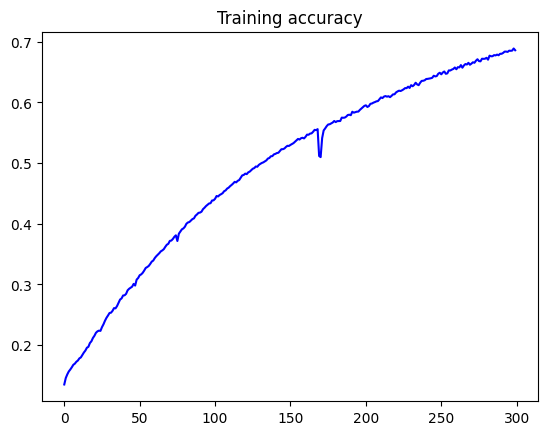

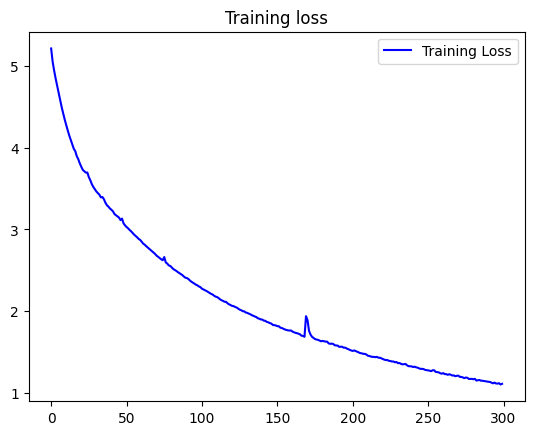

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [ ]:
!pip install pyyaml h5py 

In [ ]:
# save the model to file
model.save('lstm_model.h5')
# save the tokenizer
dump(tokenizer, open('lstm_token', 'wb'))

In [ ]:
from random import randint
from pickle import load
from keras.models import load_model
from keras.preprocessing.sequence import pad_sequences

In [ ]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words,temperature=1.0):
    '''
    INPUTS:
    model : model that was trained on text data
    tokenizer : tokenizer that was fit on text data
    seq_len : length of training sequence
    seed_text : raw string text to serve as the seed
    num_gen_words : number of words to be generated by model
    '''
    
    # Final Output
    output_text = []
    
    # Intial Seed Sequence
    input_text = seed_text
    
    # Create num_gen_words
    for i in range(num_gen_words):
        
        # Take the input text string and encode it to a sequence
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        
        # Pad sequences to our trained rate (50 words in the video)
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        # Predict Class Probabilities for each word
        pred_word_ind = model.predict_classes(pad_encoded, verbose=0)[0]
        
        # Grab word
        pred_word = tokenizer.index_word[pred_word_ind] 
        
        # Update the sequence of input text (shifting one over with the new word)
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    # Make it look like a sentence.
    return ' '.join(output_text)

In [ ]:
generated_script = generate_text(model,tokenizer,seq_len,seed_text="Watson you are",num_gen_words=50)
print(generated_script)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


all stored is given you through hand where is very such so yet that miss sutherland is its secret or openings ’ judgment from all the house was the disposition of the city branch of it and save the obvious which he had promised to have spoken to us to


In [ ]:
f =  open("generated_script.txt","w")
f.write(generated_script)
f.close()

## For Temprature = 1

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


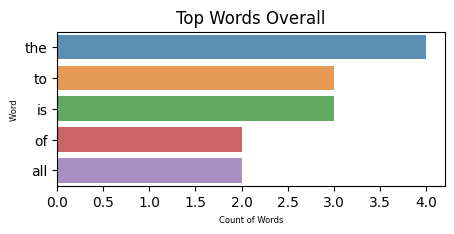

In [ ]:
t1 = open("generated_script.txt", 'rb').read().decode(encoding='utf-8')
sentences1 = sent_tokenize(t1)
tokenizer1 = RegexpTokenizer('[A-Za-z]\w+')
tokens1=tokenizer1.tokenize(t1)
df1 = pd.DataFrame(tokens1)
df1 = df1[0].value_counts()
from nltk.probability import FreqDist
freqdoctor = FreqDist()
for words in df1:
    freqdoctor[words] += 1
df1 = df1[:5,]
#freqdoctor
plt.figure(figsize=(5,2))
sns.barplot(df1.values, df1.index, alpha=0.8)
plt.title('Top Words Overall')
plt.ylabel('Word ', fontsize=6)
plt.xlabel('Count of Words', fontsize=6)
plt.show()

In [ ]:
vocab = sorted(set(t1))
print ('{} unique characters'.format(len(vocab)))

25 unique characters
